In [152]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import json

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from tensorflow_examples.models.pix2pix import pix2pix

### Segmentation

In [153]:
def load_paths(img_dir, mask_dir):
    image_paths = []
    mask_paths = []

    for filename in os.listdir(img_dir):
        if filename.endswith(".png"):
            image_path = f"{img_dir}/{filename}"
            mask_path = f"{mask_dir}/seg_{filename[4:]}"

            image_paths.append(image_path)
            mask_paths.append(mask_path)

    return image_paths, mask_paths

In [154]:
train_image_paths, train_mask_paths = load_paths("clothing_segmentation/png_images/IMAGES/train", "clothing_segmentation/png_masks/MASKS/train")
test_image_paths, test_mask_paths = load_paths("clothing_segmentation/png_images/IMAGES/test", "clothing_segmentation/png_masks/MASKS/test")

In [155]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, input_mask

In [156]:
def load_image_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.uint8)
    image = tf.image.resize(image, (128,128))

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.uint8)
    mask = tf.image.resize(mask, (128,128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image, mask = normalize(image, mask)

    # return {'image': image, 'segmentation_mask': mask}
    return image, mask

In [157]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_dataset = test_dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

dataset = {
    'train': train_dataset,
    'test': test_dataset
}

In [158]:
dataset

{'train': <ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>,
 'test': <ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>}

In [159]:
train_images = dataset['train']
test_images = dataset['test']


In [160]:
train_images

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [161]:
TRAIN_LENGTH = len(dataset['train'])
BATCH_SIZE = 40
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [162]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [163]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [164]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.savefig(f'{currentFolder}/predictions.png')
  plt.show()

In [165]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]

In [166]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [167]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [168]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [169]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [170]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = segmentation_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(segmentation_model.predict(sample_image[tf.newaxis, ...]))])

In [171]:
from IPython.core.display_functions import clear_output


class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [172]:
segmentation_model = None
currentFolder = None

In [173]:
from time import time


def run_test(optimizer, folder_name):
    global segmentation_model

    global currentFolder
    currentFolder = folder_name

    start = time()

    try:
        os.mkdir(folder_name)
    except FileExistsError:
        pass

    segmentation_model = unet_model(output_channels=OUTPUT_CLASSES)
    segmentation_model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    EPOCHS = 40
    VAL_SUBSPLITS = 5
    VALIDATION_STEPS = len(dataset['test'])//BATCH_SIZE//VAL_SUBSPLITS

    model_history = segmentation_model.fit(train_batches, epochs=EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,
                              callbacks=[DisplayCallback()])

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    end = time()


    with open("results.json", "w") as f:
        f.write(str(model_history.history) + "\n")
        f.write(str(end-start))

    plt.figure()
    plt.plot(model_history.epoch, loss, 'r', label='Training loss')
    plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(f'{currentFolder}/graph.png')
    plt.show()

1/1 [==============================] - 0s 19ms/step


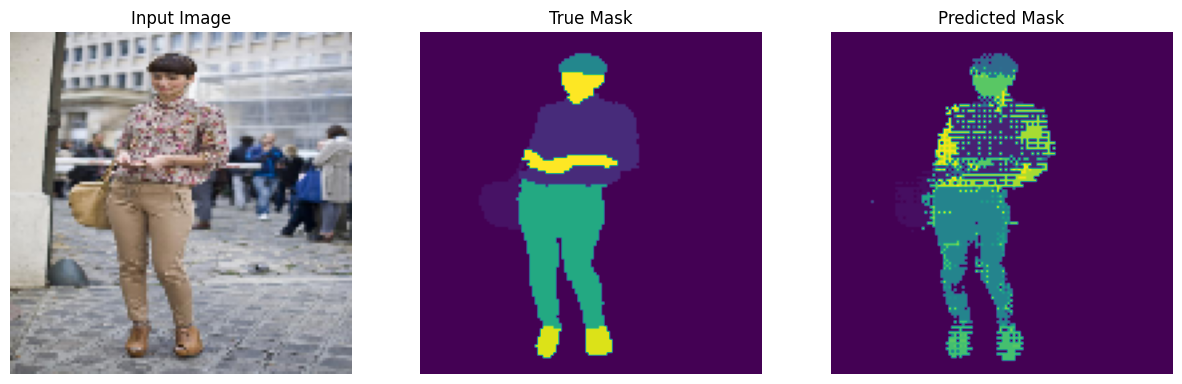


Sample Prediction after epoch 40

20/20 [==============================] - 3s 138ms/step - loss: 1.6151 - accuracy: 0.9340 - val_loss: 6.1743 - val_accuracy: 0.8338


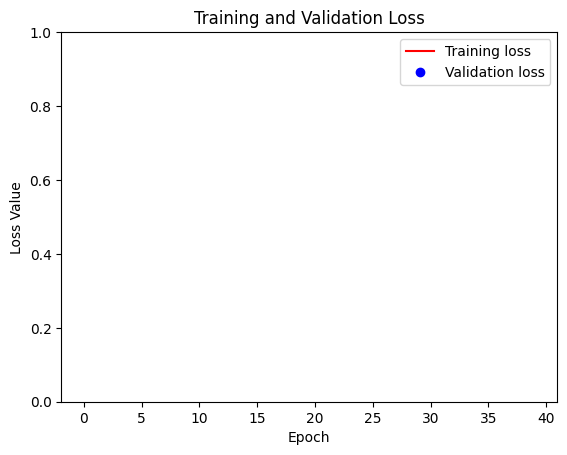

In [174]:
OUTPUT_CLASSES = 59

optimizers = {
    'adam': tf.keras.optimizers.Adam,
    'sgd': tf.keras.optimizers.SGD,
    'adamax': tf.keras.optimizers.Adamax
}


for optimizer_name in ['adam', 'sgd', 'adamax']:
    for learning_rate in [0.001, 0.01, 0.5]:
            if optimizer_name in ['adam', 'adamax']:
                for beta1, beta2 in [(0.9, 0.999), (0.8, 0.999), (0.8, 0.85)]:
                    folder_name = f"{optimizer_name}_{learning_rate}_{beta1}_{beta2}"
                    optimizer = optimizers[optimizer_name](learning_rate = learning_rate, beta_1 = beta1, beta_2 = beta2)
                    run_test(optimizer, folder_name)
            else:
                folder_name = f"{optimizer_name}_{learning_rate}"
                optimizer = optimizers[optimizer_name](learning_rate = learning_rate)
                run_test(optimizer, folder_name)

2/2 [==============================] - 0s 111ms/step


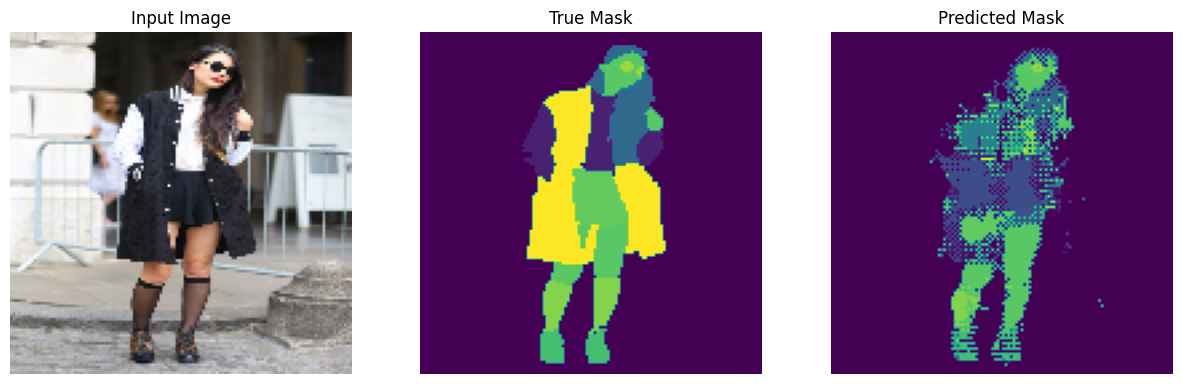

2/2 [==============================] - 0s 116ms/step


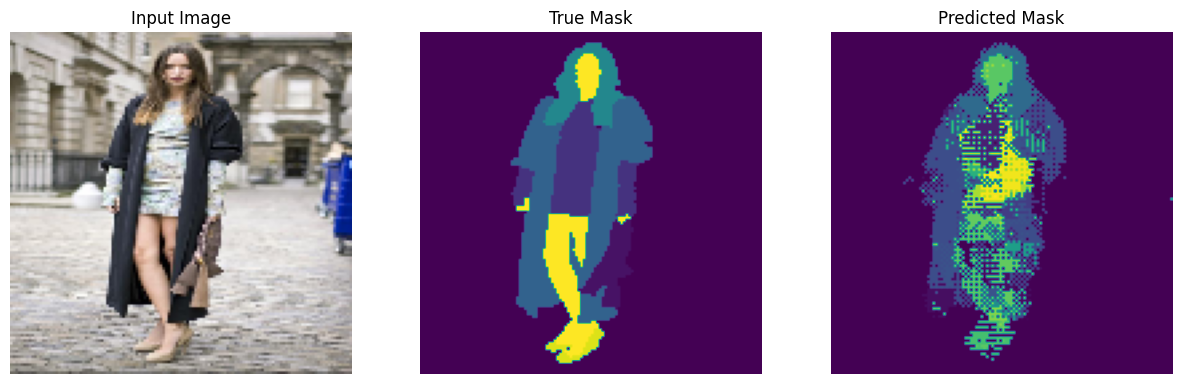

2/2 [==============================] - 0s 43ms/step


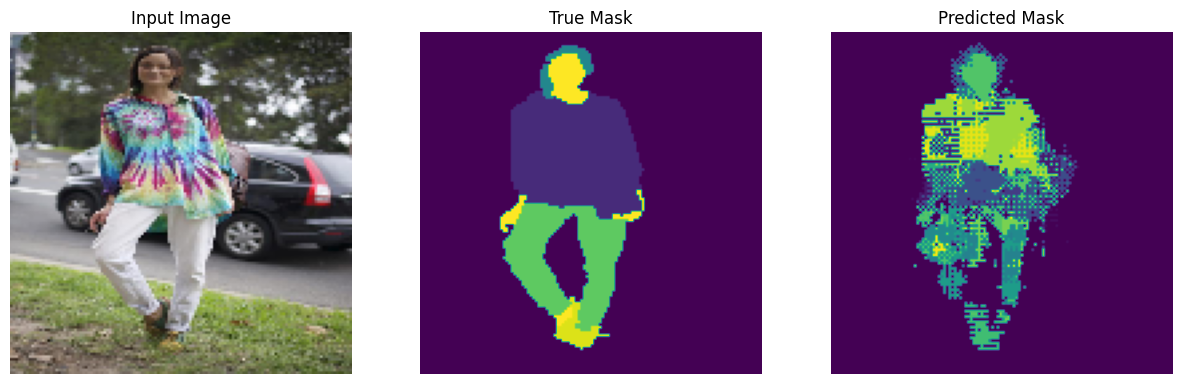

In [175]:
show_predictions(test_batches, 3)